In [20]:
import pandas as pd
import matplotlib.pyplot as plt 
import dataframe_image as dfi
import seaborn as sns 
import numpy as np 

import os
import pickle
from IPython.display import display_html 

from typing import List, Dict, Any, Optional

# ignore warnings
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

# Models
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC

## Pre-Processing
from sklearn.model_selection import train_test_split, KFold, cross_val_score #train/test split & k-fold cross validation
from sklearn.preprocessing import StandardScaler #scaler
from sklearn.decomposition import PCA #principle component analysis
from sklearn.impute import KNNImputer #impute missing data

## Scoring 
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# Data Import 
path = '/Users/rschraeder/Desktop/Projects/StanleyCupPredictions/data/'
classification_df = pd.read_csv(os.path.join(path, 'encoded_variables.csv'))
games_df = pd.read_csv(os.path.join(path, 'regular_season.csv'))
team_stats_df = pd.read_csv(os.path.join(path, 'team_stats.csv'))
categorical_df = pd.read_csv(os.path.join(path, 'categorical_teams_set_cup.csv'))


In [2]:
# Game Outcome Predictors 

x = classification_df.loc[:, (classification_df.columns != 'outcome') & (classification_df.columns != 'home_wins')]
y_away = classification_df['outcome'] # predicting away wins
y_home = classification_df['home_wins'] # predicting home wins

# Impute missing values 
# imputer = KNNImputer(n_neighbors=2)
# x = imputer.fit_transform(x)
# y = imputer.fit_transform(y)

# Creating the Train and Test Split

# Use a train and test split for initial training & testing
x_away_train, x_away_test, y_away_train, y_away_test = train_test_split(x, y_away, test_size=0.30, random_state=42)
x_home_train, x_home_test, y_home_train, y_home_test = train_test_split(x, y_home, test_size=0.30, random_state=42)

In [3]:
# Building, Training, and Testing the Model Stack
## Building each model with some fun inheritance! 

class model_development: 
        
    def __init__(self, model, predictors, target): 
        self.model = model
        self.predictors = predictors
        self.target = target 
    
    
    def ensemble(names: List[str], models: List) -> Dict[str, Any]: 
        """ Creates a dictionary with each model name and the model associated """
        models = {names[i]: models[i] for i in range(len(names))}
        return models
    

    def evaluate_ensemble(models, x_train, y_train, x_test) -> Dict[str, Any]:
        """ 
        1) Conducts PCA for feature selection and k-fold cross-validation on each model 
        2) Evaluates each model with accuracy, precision, and recall scores and returns all average scores 
        """
        
        # Conduct PCA
        pca = PCA(n_components=10)
        pca.fit_transform(x_train, y_train)
        
        # Cross Validation 
        global cv 
        cv = KFold(n_splits=5, random_state=0, shuffle=True)
        
        scores = {
            names: 
                {
                    'Accuracy': cross_val_score(models, x_train, y_train, scoring='accuracy', cv=cv).mean(), 
                    'Precision': cross_val_score(models, x_train, y_train, scoring='precision', cv=cv).mean(), 
                    'Recall': cross_val_score(models, x_train, y_train, scoring='recall', cv=cv).mean()   
                }
             for (names, models) in models.items()
        }

        return scores
       

    def predict(model, x_test): 
        predictions = model.predict(x_test)
        return predictions
    

    def stacking_model(
        estimators: List[Any],
        final_estimator, 
        x_train,
        y_train,
        x_test,
        y_test, 
        n_folds
    ):

        stack = StackingClassifier(estimators, final_estimator)
        stack = stack.fit(x_train, y_train)
        
        # Cross Validation 
        cv = KFold(n_folds, random_state=0, shuffle=True)
        
        return stack

## Pass in the models we wish to stack 

models = model_development.ensemble(
    names =  ['logistic_regression', 'kernel_svm', 'decision_tree'],
    models =  [
        LogisticRegression(),
        SVC(kernel='rbf', gamma=0.05),
        DecisionTreeClassifier()
    ]
)
models_list = list(models.items())

### Ensemble Performance

In [4]:
## Process, Train, Evaluate

# AWAY 
away_summary = model_development.evaluate_ensemble(models, x_away_train, y_away_train, x_away_test)
away_summary = pd.DataFrame.from_records(away_summary)

# HOME
home_summary = model_development.evaluate_ensemble(models, x_home_train, y_home_train, x_home_test)
home_summary = pd.DataFrame.from_records(home_summary)

def styler(df1, df2):
    """ SOURCE: https://www.thiscodeworks.com/display-two-dataframes-side-by-side-html-pandas-python-visualization/619285b06f88d700157a60d7 """
    
    df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('Away Team Model')
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('Home Team Model')
    return display_html(df1_styler._repr_html_() + df2_styler._repr_html_(), raw=True)

styler(away_summary, home_summary)

,decision_tree,kernel_svm,logistic_regression
Accuracy,0.513002,0.531398,0.588978
Precision,0.486674,0.504851,0.569942
Recall,0.475108,0.414468,0.531547
,decision_tree,kernel_svm,logistic_regression
Accuracy,0.519536,0.531398,0.588978
Precision,0.542160,0.552457,0.608240
Recall,0.547030,0.638910,0.643984


### Stacked Ensemble Performance

In [6]:
# Training and Implementing the Stacking Model

away_stacked_model = model_development.stacking_model(
        models_list,
        (make_pipeline(StandardScaler(), LinearSVC(random_state=42))), 
        x_away_train,
        y_away_train, 
        x_away_test,
        y_away_test, 
        10
)

home_stacked_model = model_development.stacking_model(
        models_list,
        (make_pipeline(StandardScaler(), LinearSVC(random_state=42))), 
        x_home_train,
        y_home_train, 
        x_home_test,
        y_home_test, 
        10
)

# Save model as pickle object
away_model_file = 'away_finalized_stacked_model.sav'
home_model_file = 'home_finalized_stacked_model.sav'
pickle.dump(away_stacked_model, open(away_model_file, 'wb'))
pickle.dump(home_stacked_model, open(home_model_file, 'wb'))

away_summary['stacked_linear_svm'] = [
    cross_val_score(away_stacked_model, x_away_train, y_away_train, scoring='accuracy', cv=cv).mean(), 
    cross_val_score(away_stacked_model, x_away_train, y_away_train, scoring='precision', cv=cv).mean(), 
    cross_val_score(away_stacked_model, x_away_train, y_away_train, scoring='recall', cv=cv).mean()   
]
home_summary['stacked_linear_svm'] = [
    cross_val_score(home_stacked_model, x_home_train, y_home_train, scoring='accuracy', cv=cv).mean(), 
    cross_val_score(home_stacked_model, x_home_train, y_home_train, scoring='precision', cv=cv).mean(), 
    cross_val_score(home_stacked_model, x_home_train, y_home_train, scoring='recall', cv=cv).mean()   
]

# dfi.export(summary, '../../images/v3_model_performance.png')

styler(away_summary, home_summary)

,decision_tree,kernel_svm,logistic_regression,stacked_linear_svm
Accuracy,0.513002,0.531398,0.588978,0.560758
Precision,0.486674,0.504851,0.569942,0.543944
Recall,0.475108,0.414468,0.531547,0.481516
,decision_tree,kernel_svm,logistic_regression,stacked_linear_svm
Accuracy,0.519536,0.531398,0.588978,0.566175
Precision,0.542160,0.552457,0.608240,0.589703
Recall,0.547030,0.638910,0.643984,0.651762


In [8]:
# Generating Predictions from the Stacked Model
# Predictions will favor the away team (1: Win, 0: Loss)

categorical_df['predicted_away_outcome'] = model_development.predict(away_stacked_model, x)
categorical_df['predicted_home_outcome'] = model_development.predict(home_stacked_model, x)

away = pd.DataFrame({
    'Predicted': categorical_df.predicted_away_outcome.value_counts(),
    'Actual': categorical_df.outcome.value_counts()
})

home = pd.DataFrame({
    'Predicted': categorical_df.predicted_home_outcome.value_counts(),
    'Actual': categorical_df.home_wins.value_counts()
})

styler(away, home)

,Predicted,Actual
0.000000,794,710
1.000000,524,608
,Predicted,Actual
1.000000,790,710
0.000000,528,608


[Text(0, 0.5, 'Win'), Text(0, 1.5, 'Loss')]

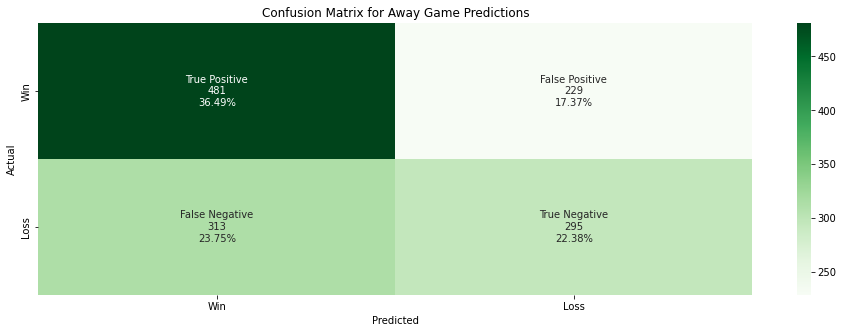

In [9]:
# Assessing Output Predictions
"""
Per the classification of the categorical game outcome, predictions are: 
- _*Home Win*_ : 0
- _*Away Win*_ : 1

The confusion matrix will show the: 
- True Positives
- False Positives
- True Negatives
- False Negatives
"""

away_conf_matrix = confusion_matrix(categorical_df['outcome'], categorical_df['predicted_away_outcome'])
home_conf_matrix = confusion_matrix(categorical_df['home_wins'], categorical_df['predicted_home_outcome'])

plt.figure(figsize=(16, 5))

def matrix_plot_labels(matrix):
    group_names = ['True Positive', 'False Positive', 'False Negative', 'True Negative']

    counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]
    percentage = ["{0:.2%}".format(value) for value in matrix.flatten()/np.sum(matrix)]

    labels = [f"{i}\n{j}\n{k}" for i, j, k in zip(group_names, counts, percentage)]
    labels = np.asarray(labels).reshape(2,2)

    return labels

ax = sns.heatmap(away_conf_matrix, annot=matrix_plot_labels(away_conf_matrix), cmap='Greens', fmt='')
ax.set_title('Confusion Matrix for Away Game Predictions')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['Win', 'Loss'])
ax.yaxis.set_ticklabels(['Win', 'Loss'])

plt.savefig('../../images/v2_confusion_matrix_away.png')

[Text(0, 0.5, 'Win'), Text(0, 1.5, 'Loss')]

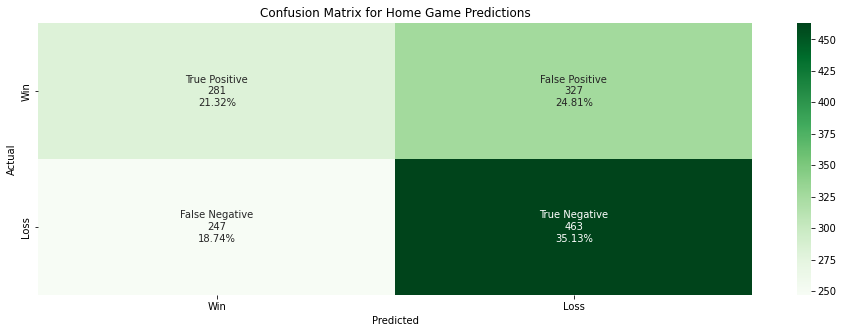

In [10]:
plt.figure(figsize=(16, 5))
ax = sns.heatmap(home_conf_matrix, annot=matrix_plot_labels(home_conf_matrix), cmap='Greens', fmt='')
ax.set_title('Confusion Matrix for Home Game Predictions')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['Win', 'Loss'])
ax.yaxis.set_ticklabels(['Win', 'Loss'])

plt.savefig('../../images/v2_confusion_matrix_home.png')

# Evaluation

In summary, the models are slightly better in performance but cannot be entirely trusted. The stacked Linear SVM algorithm on top of the ensemble did not have valuable performance detecting true losses or wins, and is fairly even with its overall performance giving around 50% accuracy presumably.

>For insight, we can compare this in a tabular format:


In [11]:
preds_df = categorical_df[['date', 'away_team', 'home_team', 'predicted_away_outcome', 'predicted_home_outcome', 'outcome', 'home_wins']].rename(columns={'outcome': 'away_result', 'home_wins': 'home_result'})
preds_df.predicted_away_outcome = preds_df.predicted_away_outcome.apply(lambda x: 'Win' if x == 1 else 'Loss')
preds_df.predicted_home_outcome = preds_df.predicted_home_outcome.apply(lambda x: 'Win' if x == 1 else 'Loss')
preds_df.home_result = preds_df.home_result.apply(lambda x: 'Win' if x == 1 else 'Loss')
preds_df.away_result = preds_df.away_result.apply(lambda x: 'Win' if x == 1 else 'Loss')
preds_df

,date,away_team,home_team,predicted_away_outcome,predicted_home_outcome,away_result,home_result
0,2021-10-12,Pittsburgh Penguins,Tampa Bay Lightning,Loss,Win,Win,Loss
1,2021-10-14,Pittsburgh Penguins,Florida Panthers,Loss,Win,Loss,Win
2,2021-11-09,Pittsburgh Penguins,Chicago Blackhawks,Loss,Win,Loss,Win
3,2021-11-13,Pittsburgh Penguins,Ottawa Senators,Win,Loss,Loss,Win
4,2021-11-14,Pittsburgh Penguins,Washington Capitals,Win,Loss,Loss,Win
...,...,...,...,...,...,...,...
1313,2022-04-14,New Jersey Devils,Colorado Avalanche,Loss,Win,Loss,Win
1314,2022-04-16,New Jersey Devils,Seattle Kraken,Loss,Win,Loss,Win
1315,2022-04-18,New Jersey Devils,Vegas Golden Knights,Loss,Win,Win,Loss
1316,2022-04-26,New Jersey Devils,Ottawa Senators,Loss,Win,Loss,Win


Given the predictions favor an away win, this can predict if the away team will win a game or not. This is because we can use an _unbiased_ prediction without home field advantage. 

... For fun, I'm an Avs fan. Let's see how that panned out 

In [16]:
def evaluate_predictions(subset: pd.DataFrame(), correct: int, incorrect: int):

    try :
        print({
            'Correct Predictions': correct, 
            'Incorrect Predictions': incorrect, 
            'Overall Correct': f'{((correct) / (correct + incorrect) * 100)}%'
        
        })
    except Exception as e:
         print(f"{e}")

    return
      
avs_away_games = preds_df[preds_df['away_team']=='Colorado Avalanche']
avscorrect = len(avs_away_games[avs_away_games.predicted_away_outcome == avs_away_games.away_result]) # accurate predictions
avsincorrect = len(avs_away_games[avs_away_games.predicted_away_outcome != avs_away_games.away_result]) # innaccurate predictions

avs_home_games = preds_df[preds_df['home_team']=='Colorado Avalanche']
avs_home_correct = len(avs_home_games[avs_home_games.predicted_home_outcome == avs_home_games.home_result]) # accurate predictions
avs_home_incorrect = len(avs_home_games[avs_home_games.predicted_home_outcome != avs_home_games.home_result]) # innaccurate predictions

away_correct = len(preds_df[preds_df.predicted_away_outcome == preds_df.away_result]) # accurate predictions
away_incorrect = len(preds_df[preds_df.predicted_away_outcome != preds_df.away_result]) # innaccurate predictions

home_correct = len(preds_df[preds_df.predicted_home_outcome == preds_df.home_result]) # accurate predictions
home_incorrect = len(preds_df[preds_df.predicted_home_outcome != preds_df.home_result]) # innaccurate predictions

In [17]:
# Avalanche Away Games 

evaluate_predictions(avs_away_games, avscorrect, avsincorrect)

{'Correct Predictions': 23, 'Incorrect Predictions': 20, 'Overall Correct': '53.48837209302325%'}


In [18]:
# Avalanche Home Games 

evaluate_predictions(avs_home_games, avs_home_correct, avs_home_incorrect)

{'Correct Predictions': 25, 'Incorrect Predictions': 20, 'Overall Correct': '55.55555555555556%'}


In [19]:
# Original Data 

evaluate_predictions(preds_df, away_correct, away_incorrect)
evaluate_predictions(preds_df, home_correct, home_incorrect)

{'Correct Predictions': 776, 'Incorrect Predictions': 542, 'Overall Correct': '58.877086494688925%'}
{'Correct Predictions': 744, 'Incorrect Predictions': 574, 'Overall Correct': '56.449165402124436%'}


## Summary

The model is not as favorable when considering all features and is at best 58.87% accurate. When matched to the actual data, few predictions are correct